## Introduction to Social Network Analysis: Network Creation and Visualization

We'll start by loading the required libraries. The only new one is [networkX](https://networkx.org/documentation/stable/index.html), the main python library for network analysis.

In [15]:
from pathlib import Path
from collections import defaultdict

import pandas as pd

import matplotlib.pyplot as plt

import networkx as nx

import pickle

### Load and explore the data

We will use a data set about actors and movies they played in as well as about the actors' nominations for American Academy Awards (Oscars).
The data set is available from Kaggle as the ["Oscar nominations and filmographies since 1972"](https://www.kaggle.com/datasets/milanjanosov/oscar-nominations-and-filmographies-since-1972) data set. More information about this dataset and one apporach to its use in network analysis is available in [this DataViz artcle](https://nightingaledvs.com/50-years-of-oscars-acting-success-and-collaboration/).

A side note: you might be interested in exploring the [Cinemagoer](https://cinemagoer.github.io/) python package for  retrieving data about movies and people from the IMDb movie database.

In [16]:
filmographies = pd.read_csv(Path.cwd() / 'data' / 'filmographies.csv')
nominations = pd.read_csv(Path.cwd() / 'data' / 'nomination_stats.csv')

We'll start by exploring the data

In [17]:
filmographies.head()

,name,name_id,title,title_id,year,kind,position
0,Richard Harris,nm0001321,"Today Mexico, Tomorrow the World",tt8682736,1972,movie,self
1,Ellen Burstyn,nm0000995,The King of Marvin Gardens,tt0068805,1972,movie,actress
2,Paul Winfield,nm0934902,Trouble Man,tt0069414,1972,movie,actor
3,Paul Winfield,nm0934902,Sounder,tt0069303,1972,movie,actor
4,Adolph Caesar,nm0128360,Hammer,tt0068673,1972,movie,actor


In [18]:
filmographies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76034 entries, 0 to 76033
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   name      76034 non-null  object
 1   name_id   76034 non-null  object
 2   title     76034 non-null  object
 3   title_id  76034 non-null  object
 4   year      76034 non-null  int64 
 5   kind      76034 non-null  object
 6   position  76034 non-null  object
dtypes: int64(1), object(6)
memory usage: 4.1+ MB


In [19]:
filmographies.kind.value_counts()

kind
movie         68983
tv movie       6316
video game      505
tv short        230
Name: count, dtype: int64

In [20]:
filmographies.position.value_counts()

position
self                                          23985
actor                                         19531
actress                                       14412
archive footage                                9644
soundtrack                                     2434
producer                                       2167
thanks                                         2034
director                                        710
writer                                          630
additional crew                                 164
composer                                        139
music department                                 79
editor                                           21
stunts                                           16
camera and electrical department                 16
cinematographer                                  10
art department                                    9
second unit director or assistant director        5
sound department                                  5
cos

In [21]:
nominations.head()

,name,name_id,category,year,outcome
0,Margaret Leighton,nm0500364,Best Actress in a Supporting Role,1972,nominee
1,George C. Scott,nm0001715,Best Actor in a Leading Role,1972,nominee
2,Peter Finch,nm0002075,Best Actor in a Leading Role,1972,nominee
3,Topol,nm0867694,Best Actor in a Leading Role,1972,nominee
4,Walter Matthau,nm0000527,Best Actor in a Leading Role,1972,nominee


In [22]:
nominations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   name      1200 non-null   object
 1   name_id   1200 non-null   object
 2   category  1200 non-null   object
 3   year      1200 non-null   int64 
 4   outcome   1200 non-null   object
dtypes: int64(1), object(4)
memory usage: 47.0+ KB


In [23]:
nominations.outcome.value_counts()

outcome
nominee    1000
winner      200
Name: count, dtype: int64

### Create a network of actors who acted in the same movie

We will create an undirected graph, as the relationship of acting in the same movie is mutual

In [24]:
G = nx.Graph()

#### Add nodes to the network

Add a node for each actor / actress

In [33]:
actors_df = filmographies.loc[filmographies.position.isin(['actor', 'actress']) & (filmographies.kind=="movie")]
actors_df.shape

(28725, 7)

Check if we need name_id as unique identifiers or we can rely on actor / actress names to uniquely identify them

In [34]:
actors_df.name.nunique() == actors_df.name_id.nunique()

True

Create a node for each actor / actress using their names as node identifiers and labels.

There are different ways for adding nodes to a graph, but the most often used one is via the `add_nodes_from()` method that receives a list of values representing node names or a list of tuples holding not only node names but also attributes

In [35]:
actors = actors_df.name.unique().tolist()
print(f"Number of actors: {len(actors)}")

Number of actors: 546


In [36]:
G.add_nodes_from(actors)
print(G)

Graph with 546 nodes and 0 edges


To access graph nodes, use `G.nodes()` which returns an object of type `NodeView`.
It is a dict-like and set-like object that provides a *view* into the nodes and their attributes within a graph. It does not store a separate copy of the node data but rather reflects the current state of the graph.

In [42]:
for node in list(G.nodes())[:5]:
    print(node)

Ellen Burstyn
Paul Winfield
Adolph Caesar
Robert Downey Jr.
Maureen Stapleton


Next, we add attributes to nodes. In particular, we will add three attributes:
* number of movies an actor / actress played in,
* number of Oscar nominations,
* number of Oscars won

In [38]:
num_films = actors_df.groupby('name').size()
num_films

name
Abigail Breslin     39
Adam Driver         37
Adolph Caesar       14
Adriana Barraza     40
Adrien Brody        62
                    ..
Winona Ryder        57
Woody Allen         39
Woody Harrelson     86
Yalitza Aparicio     7
Yuh-Jung Youn       32
Length: 546, dtype: int64

In [39]:
num_films.describe()

count    546.000000
mean      52.609890
std       34.334029
min        1.000000
25%       31.000000
50%       48.000000
75%       69.750000
max      468.000000
dtype: float64

In [43]:
for node in G.nodes():
    G.nodes[node]['num_films'] = num_films.get(node, 0)

In [44]:
nominees_df = nominations.loc[nominations.outcome == 'nominee',]
num_nominations = nominees_df.groupby('name').size()
num_nominations

name
Abigail Breslin     1
Adam Driver         2
Adolph Caesar       1
Adriana Barraza     1
Adrien Brody        1
                   ..
Winona Ryder        2
Woody Allen         1
Woody Harrelson     3
Yalitza Aparicio    1
Youn Yuh-jung       1
Length: 556, dtype: int64

In [45]:
num_nominations.describe()

count    556.000000
mean       1.798561
std        1.584519
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       21.000000
dtype: float64

In [ ]:
# num_nominations[num_nominations == 21]

In [47]:
for node in G.nodes():
    G.nodes[node]['num_nominations'] = num_nominations.get(node, 0)

In [48]:
winners_df = nominations.loc[nominations.outcome == 'winner',]
num_awards = winners_df.groupby('name').size()
for node in G.nodes():
    G.nodes[node]['num_awards'] = num_awards.get(node, 0)

In [52]:
# setting data to True to show attribute values
for node in list(G.nodes(data=True))[:10]:
    print(node)

('Ellen Burstyn', {'num_films': 71, 'num_nominations': 5, 'num_awards': 1})
('Paul Winfield', {'num_films': 58, 'num_nominations': 1, 'num_awards': 0})
('Adolph Caesar', {'num_films': 14, 'num_nominations': 1, 'num_awards': 0})
('Robert Downey Jr.', {'num_films': 83, 'num_nominations': 2, 'num_awards': 0})
('Maureen Stapleton', {'num_films': 27, 'num_nominations': 2, 'num_awards': 1})
('Dustin Hoffman', {'num_films': 57, 'num_nominations': 5, 'num_awards': 2})
('Louis Gossett Jr.', {'num_films': 82, 'num_nominations': 1, 'num_awards': 1})
('Joel Grey', {'num_films': 23, 'num_nominations': 1, 'num_awards': 1})
('Bruce Dern', {'num_films': 101, 'num_nominations': 2, 'num_awards': 0})
('Kathleen Quinlan', {'num_films': 54, 'num_nominations': 1, 'num_awards': 0})


#### Adding edges to the graph

Add edges between actors who acted in the same movie

In [55]:
edges_dict = dict()

for title_id, group in actors_df.groupby('title_id'):
    title_actors = group['name'].tolist()
    for i in range(len(title_actors)):
        for j in range(i+1, len(title_actors)):
            if (title_actors[i], title_actors[j]) in edges_dict.keys():
                edges_dict[(title_actors[i], title_actors[j])] += 1
            elif (title_actors[j], title_actors[i]) in edges_dict.keys():
                edges_dict[(title_actors[j], title_actors[i])] += 1
            else:
                edges_dict[(title_actors[i], title_actors[j])] = 1

In [60]:
for actor_pair, freq in edges_dict.items():
    source, target = actor_pair
    G.add_edge(source, target, weight=freq)

print("Edge count", G.number_of_edges())

Edge count 18038


We can access edges via `G.edges()` and if we want to access edge attributes (e.g., weight), we set the `data` argument to True:

In [61]:
for edge in list(G.edges(data=True))[:10]:
    print(edge)

('Ellen Burstyn', 'Bruce Dern', {'weight': 2})
('Ellen Burstyn', 'Jack Nicholson', {'weight': 1})
('Ellen Burstyn', 'Jason Miller', {'weight': 1})
('Ellen Burstyn', 'Linda Blair', {'weight': 1})
('Ellen Burstyn', 'Max von Sydow', {'weight': 1})
('Ellen Burstyn', 'Jodie Foster', {'weight': 1})
('Ellen Burstyn', 'Harvey Keitel', {'weight': 4})
('Ellen Burstyn', 'Diane Ladd', {'weight': 2})
('Ellen Burstyn', 'Laura Dern', {'weight': 2})
('Ellen Burstyn', 'Art Carney', {'weight': 1})


A graph is internally represented as an adjacency matrix or as an edge list.

The **adjacency matrix** is a matrix of NxN dimension, where N is the number of nodes. It is a sparse matrix, with values different than zero indicating an edge between two nodes. In case of undirected graphs, such as the current one, it is a symmetric matrix.

In networkX, we can access this internal, matrix, representation as follows:

In [62]:
adj_matrix = nx.to_pandas_adjacency(G)
adj_matrix.iloc[:5,:5]

,Ellen Burstyn,Paul Winfield,Adolph Caesar,Robert Downey Jr.,Maureen Stapleton
Ellen Burstyn,0.0,0.0,0.0,0.0,0.0
Paul Winfield,0.0,0.0,0.0,0.0,0.0
Adolph Caesar,0.0,0.0,0.0,0.0,0.0
Robert Downey Jr.,0.0,0.0,0.0,0.0,0.0
Maureen Stapleton,0.0,0.0,0.0,0.0,0.0


In case of large graphs, such as the current one, a more efficient graph representation is **edge list**, which is a list of source - target node pairs, with associated weight (or other edge attributes) if available. In networkX, it can be accessed via the `adjacency_matrix()` function (which is quite unusal and confusing):

In [63]:
adj_matrix = nx.adjacency_matrix(G)
print(adj_matrix)

  (0, 6)	1
  (0, 8)	2
  (0, 14)	1
  (0, 16)	2
  (0, 18)	2
  (0, 25)	1
  (0, 26)	1
  (0, 30)	1
  (0, 41)	1
  (0, 45)	1
  (0, 47)	1
  (0, 48)	1
  (0, 49)	1
  (0, 54)	1
  (0, 55)	1
  (0, 62)	1
  (0, 65)	1
  (0, 76)	1
  (0, 77)	1
  (0, 78)	2
  (0, 91)	3
  (0, 103)	1
  (0, 119)	2
  (0, 123)	1
  (0, 124)	1
  :	:
  (544, 457)	1
  (544, 486)	1
  (544, 502)	1
  (544, 513)	1
  (544, 529)	1
  (545, 70)	1
  (545, 134)	1
  (545, 194)	1
  (545, 244)	1
  (545, 246)	1
  (545, 264)	1
  (545, 292)	1
  (545, 305)	1
  (545, 308)	1
  (545, 418)	1
  (545, 425)	1
  (545, 446)	1
  (545, 447)	1
  (545, 471)	1
  (545, 481)	1
  (545, 499)	1
  (545, 511)	1
  (545, 519)	1
  (545, 522)	1
  (545, 523)	2


#### Visualising a graph

Since the actors graph is quite large for initial visualisation, we'll focus on its subset (subgraph): actors who won multiple oscars, connected if they co-starred in the same movie

In [64]:
multi_oscars_filter = [node for node, attr in G.nodes(data=True) if attr.get('num_awards') > 1]
G_multi_oscar_winners = G.subgraph(multi_oscars_filter)
print(G_multi_oscar_winners)

Graph with 24 nodes and 84 edges


A key thing to decide on when creating a graph visualisation is how to lay out the graph nodes, that is, what layout algorithm and the corresponding networkX's layout function to use.

NetworkX includes a variety of built-in layout algorithms. The following are those that are most often used:
* `spring_layout` (Fruchterman-Reingold algorithm): The default layout, which uses a force-directed approach to position nodes, simulating attractive forces between connected nodes and repulsive forces between all other nodes.
* `circular_layout`: Arranges nodes in a circle. This is useful for emphasizing cyclic structures (when present).
* `random_layout`: Places nodes randomly within a unit square.
* `kamada_kawai_layout`: Uses a path-length cost-function to position nodes, often resulting in aesthetically pleasing layouts that reflect the graph's structure well.

First, we create just a basic visualisation

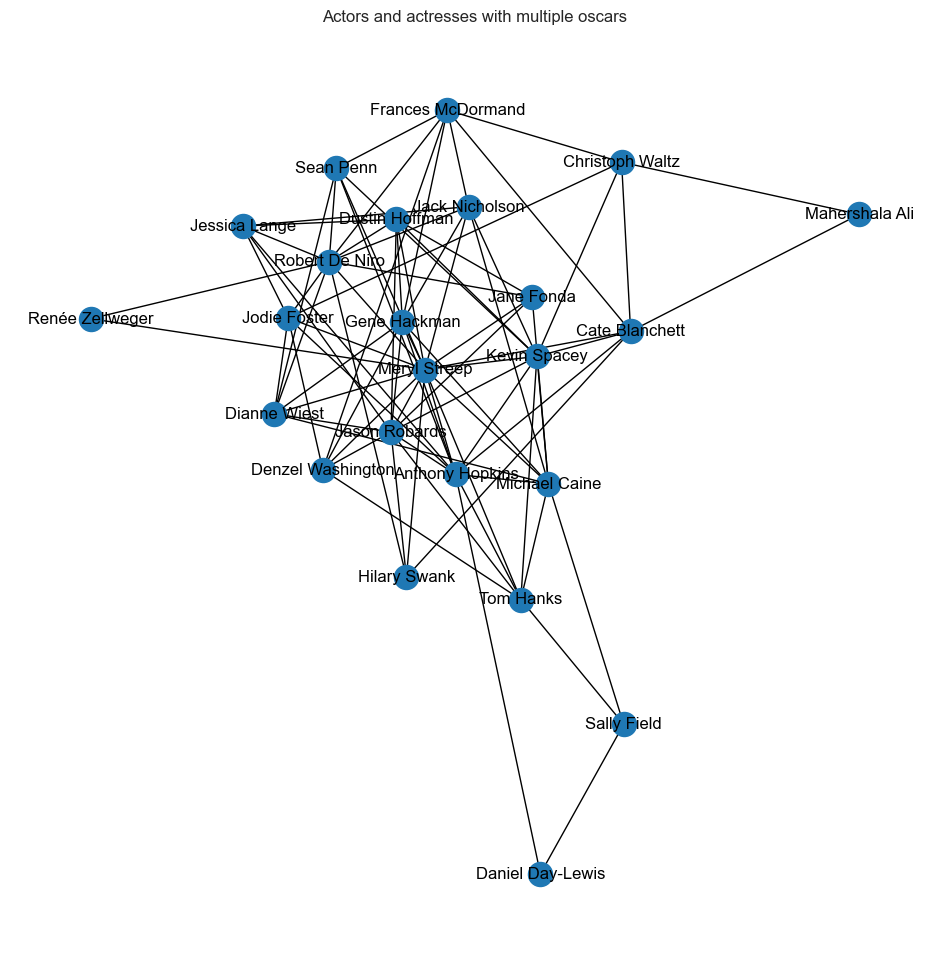

In [65]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G_multi_oscar_winners,
                       seed=1,
                       k=0.75) # controls how close the nodes are; increasing it moves nodes apart

nx.draw_networkx_nodes(G_multi_oscar_winners, pos)
nx.draw_networkx_edges(G_multi_oscar_winners, pos)
nx.draw_networkx_labels(G_multi_oscar_winners, pos)

plt.title("Actors and actresses with multiple oscars")

plt.axis('off')
plt.show()

We can make the visualisation more informative by:
* scaling nodes so that their size reflects one of nodes' attributes, for example, number of movies an actor played in
* setting the node colour to represent another node feature - for example, number of awards an actor received
* setting edge width to correspond to the strength of connection between two nodes

In [66]:
# making the node size a function of the number of films the actor / actress acted in
node_sizes = [30 + 9*G_multi_oscar_winners.nodes[n]['num_films'] for n in G_multi_oscar_winners.nodes()]

# getting the number of awards each actor / actress won, to serve for node color selection from a color map,
# so that the color of a node reflects the number of awards won
node_colors = [G_multi_oscar_winners.nodes[n]['num_awards'] for n in G_multi_oscar_winners.nodes()]

# extract edge weights to be used for determining the edge width
edge_width = [w['weight'] for _, _, w in G_multi_oscar_winners.edges(data=True)]

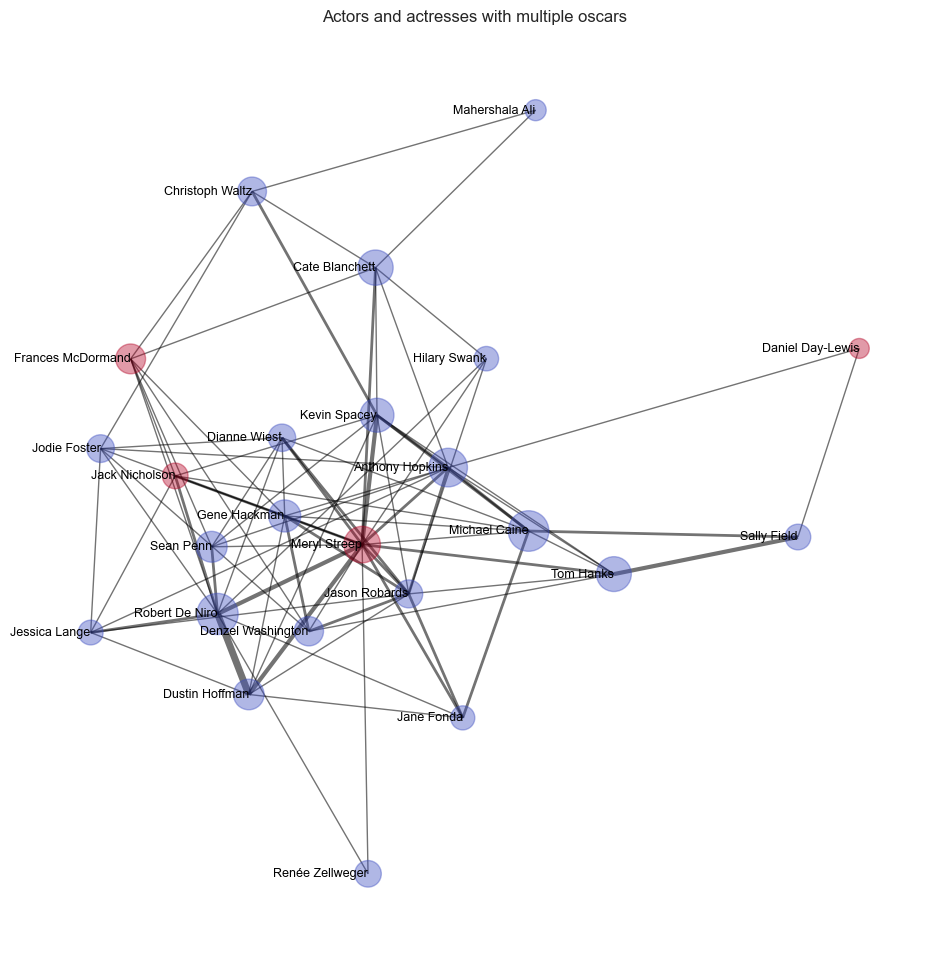

In [80]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G_multi_oscar_winners, seed=18, k=0.75)
# pos = nx.kamada_kawai_layout(G_multi_oscar_winners, weight='weight')

nx.draw_networkx_nodes(G_multi_oscar_winners, pos,
                       node_size=node_sizes,
                       node_color=node_colors, cmap='coolwarm', alpha=0.4)
nx.draw_networkx_edges(G_multi_oscar_winners, pos,
                       width=edge_width, alpha=0.55)
nx.draw_networkx_labels(G_multi_oscar_winners, pos,
                        font_size=9,
                        horizontalalignment='right')

plt.title("Actors and actresses with multiple oscars")

plt.axis('off')
plt.show()

#### Save graph

There are several common formats for storing graphs:
* GraphML: An XML-based format that is often used for storing and sharing edge and node attribute data.
* GML (Graph Modeling Language): A simpler, text-based format supported by many tools.
* GEXF (Graph Exchange XML Format): Another XML-based format, often used with visualization tools like Gephi.
* Edge List: A simple format where each line holds a pair of source and target nodes representing an edge

The use of these formats is recommended if one needs to share the graph with other, non-Python software.
However, if a graph is be used in python only, then serialising it in a usual way - via pickle - is recommended.

In [ ]:
nx.write_edgelist(G, Path.cwd() / 'graphs' / 'actors.adjlist')
nx.write_edgelist(G_multi_oscar_winners, Path.cwd() / 'graphs' / 'multi_oscar_winners.adjlist')

In [ ]:
with open(Path.cwd() / 'graphs' / 'actors.pkl', 'wb') as fobj:
    pickle.dump(G, fobj)

with open(Path.cwd() / 'graphs' / 'multi_oscar_winners.pkl', 'wb') as fobj:
    pickle.dump(G_multi_oscar_winners, fobj)